In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import os
import zipfile

In [2]:
!pip install kaggle
# Upload your Kaggle API credentials JSON file
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset from Kaggle
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

Saving kaggle.json to kaggle.json
 99% 118M/119M [00:06<00:00, 22.6MB/s]
100% 119M/119M [00:06<00:00, 19.2MB/s]


In [3]:
with zipfile.ZipFile("chest-ctscan-images.zip", "r") as zip_ref:
    zip_ref.extractall("/content/chest-ctscan-images")

In [4]:
import numpy as np
import cv2
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Function to load the dataset
def load_dataset(dataset_folder_path):
    data = []
    labels = []
    label_to_int = {}  # Dictionary to map labels to integers
    int_label = 0
    for folder_name in os.listdir(dataset_folder_path):
        if folder_name not in label_to_int:
            label_to_int[folder_name] = int_label
            int_label += 1
        folder_path = os.path.join(dataset_folder_path, folder_name)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))  # VGG19 input size
            data.append(image)
            labels.append(folder_name)
    # Convert the lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    return data, labels, label_to_int
# Load the test dataset
test_dataset_path = "/content/chest-ctscan-images/Data/test/"
test_data, test_labels, label_to_int = load_dataset(test_dataset_path)

# Load the train dataset
train_dataset_path = "/content/chest-ctscan-images/Data/train/"
train_data, train_labels, label_to_int = load_dataset(train_dataset_path)

# Load the validation dataset
valid_dataset_path = "/content/chest-ctscan-images/Data/valid/"
valid_data, valid_labels, label_to_int = load_dataset(valid_dataset_path)

# Shuffle the datasets
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)
valid_data, valid_labels = shuffle(valid_data, valid_labels, random_state=42)

# Normalize the pixel values to [0, 1]
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0
valid_data = valid_data.astype('float32') / 255.0

# Convert the labels to integers using label_to_int dictionary
train_labels_mapped = np.array([label_to_int[label] for label in train_labels])
# Convert the labels to integers using label_to_int dictionary
train_labels_mapped = np.array([label_to_int[label] for label in train_labels])

# Convert the labels to integers using label_to_int dictionary
test_labels_mapped = []
for label in test_labels:
    if label in label_to_int:
        test_labels_mapped.append(label_to_int[label])
    else:
        # Handle missing or unexpected labels (e.g., assign a unique integer or skip the sample)
        # You can also ignore the sample if needed.
        pass

test_labels_mapped = np.array(test_labels_mapped)
# Convert the labels to integers using label_to_int dictionary
valid_labels_mapped = np.array([label_to_int[label] for label in valid_labels])
valid_labels_mapped = np.array([label_to_int[label] for label in valid_labels])
# Convert the labels to one-hot encoded vectors
num_classes = len(label_to_int)
train_labels = tf.keras.utils.to_categorical(train_labels_mapped, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels_mapped, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels_mapped, num_classes)
# Rest of the code for building, training, and evaluating the model...

In [5]:
from sklearn.model_selection import train_test_split
# Split the original training dataset into new training and test datasets
new_train_data, new_test_data, new_train_labels, new_test_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)
# Combine the new training and test datasets
combined_data = np.concatenate((new_train_data, new_test_data), axis=0)
combined_labels = np.concatenate((new_train_labels, new_test_labels), axis=0)

# Shuffle the combined dataset
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=42)

# Split the shuffled dataset into final training and test datasets
train_data, test_data, train_labels, test_labels = train_test_split(
    combined_data, combined_labels, test_size=0.2, random_state=42
)

# Print the sizes of the final datasets
print("Final training dataset size:", len(train_data))
print("Final test dataset size:", len(test_data))

Final training dataset size: 490
Final test dataset size: 123


In [6]:
# Build VGG19 model , Very Deep Convolutional Networks for Large-Scale Image Recognition
input_shape = (224, 224, 3)  # VGG19 input size
input_layer = Input(shape=input_shape)
#The code creates the VGG19 model by stacking various layers to form five convolutional blocks.
#Each block consists of multiple convolutional layers followed by max-pooling.
#The padding='same' argument ensures that the spatial dimensions of the output remain the same as the input.
#The max-pooling layers (MaxPooling2D) reduce the spatial dimensions of the feature maps while retaining their important features.
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
#convert 2d into 1d
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
output_layer = Dense(num_classes, activation='softmax', name='predictions')(x)
vgg19_model = Model(inputs=input_layer, outputs=output_layer)
# Compile the model
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
vgg19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
print(len(train_data), len(train_labels))
print(len(test_data), len(test_labels))
print(len(valid_data), len(valid_labels))

490 490
123 123
72 72


In [8]:
# Training the model
batch_size = 32
epochs = 10
history = vgg19_model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))

Epoch 1/10
16/16 [==============================] - 49s 1s/step - loss: 1.4574 - accuracy: 0.2347 - val_loss: 1.3671 - val_accuracy: 0.2764
Epoch 2/10
16/16 [==============================] - 8s 485ms/step - loss: 1.3875 - accuracy: 0.3061 - val_loss: 1.3632 - val_accuracy: 0.3496
Epoch 3/10
16/16 [==============================] - 8s 489ms/step - loss: 1.3760 - accuracy: 0.3102 - val_loss: 1.3572 - val_accuracy: 0.3496
Epoch 4/10
16/16 [==============================] - 8s 493ms/step - loss: 1.3752 - accuracy: 0.3102 - val_loss: 1.3538 - val_accuracy: 0.3496
Epoch 5/10
16/16 [==============================] - 8s 498ms/step - loss: 1.3744 - accuracy: 0.3102 - val_loss: 1.3555 - val_accuracy: 0.3496
Epoch 6/10
16/16 [==============================] - 8s 502ms/step - loss: 1.3792 - accuracy: 0.3102 - val_loss: 1.3525 - val_accuracy: 0.3496
Epoch 7/10
16/16 [==============================] - 8s 508ms/step - loss: 1.3737 - accuracy: 0.3102 - val_loss: 1.3606 - val_accuracy: 0.3496
Epoch 8/

In [9]:
test_loss, test_accuracy = vgg19_model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 [==============================] - 1s 151ms/step - loss: 1.3537 - accuracy: 0.3496
Test Loss: 1.3536657094955444
Test Accuracy: 0.34959349036216736


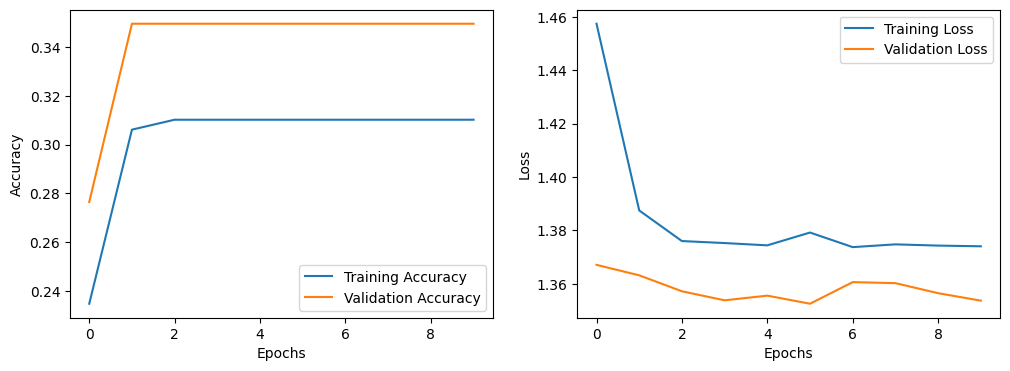

In [10]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Plot the training history
plot_history(history)

4/4 [==============================] - 1s 141ms/step


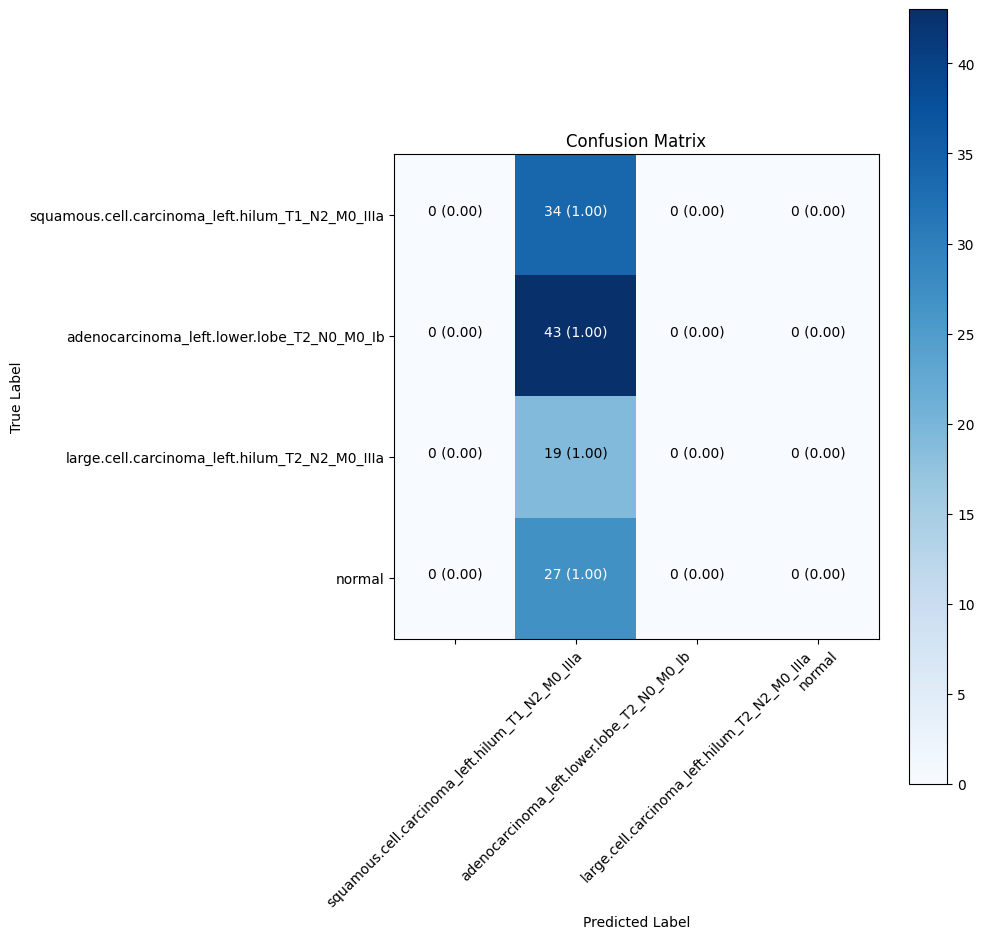

In [11]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Assuming you have already trained your vgg19_model and obtained predictions on the test set
predictions = vgg19_model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

# Get class labels from the label_to_int dictionary
label_to_int_inv = {v: k for k, v in label_to_int.items()}
classes = [label_to_int_inv[i] for i in range(num_classes)]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix values for better readability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Use white text for darker cells, and black text otherwise
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + " (" + format(cm_normalized[i, j], '.2f') + ")",
             horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
from sklearn.metrics import accuracy_score
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Compute the accuracy
accuracy = accuracy_score(np.argmax(test_labels, axis=1), predicted_labels)
# Display the accuracy percentage
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 34.96%


In [13]:
from sklearn.metrics import classification_report
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Compute the classification report
report = classification_report(np.argmax(test_labels, axis=1), predicted_labels)
# Display the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.35      1.00      0.52        43
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        27

    accuracy                           0.35       123
   macro avg       0.09      0.25      0.13       123
weighted avg       0.12      0.35      0.18       123



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
recall = recall_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
f1 = f1_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

Precision: 0.12
Recall: 0.35
F1-Score: 0.18


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


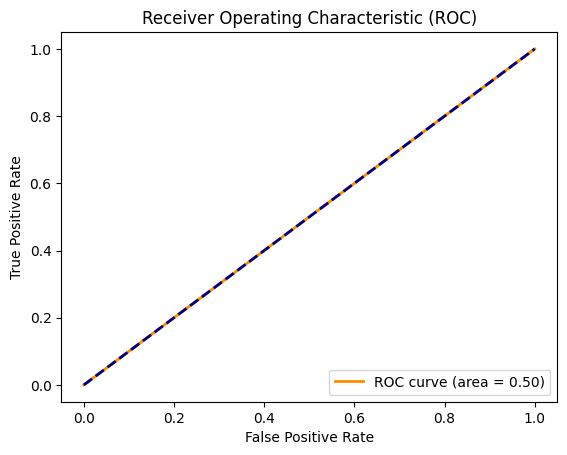

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Assuming binary classification (two classes) for simplicity
# If your problem is multi-class, you need to modify the code accordingly
fpr, tpr, thresholds = roc_curve(test_labels[:, 1], predictions[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

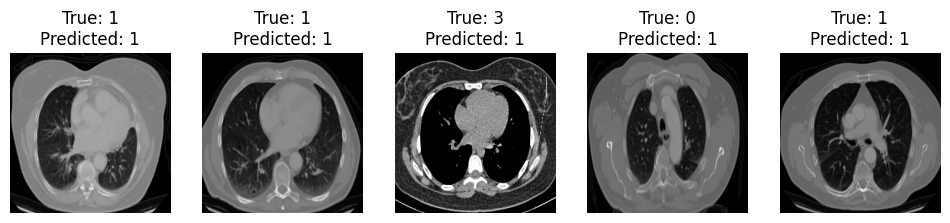

In [16]:
import random
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Choose a random subset of test data and corresponding true and predicted labels
random_indices = random.sample(range(len(test_data)), 5)
sample_images = test_data[random_indices]
sample_true_labels = np.argmax(test_labels[random_indices], axis=1)
sample_predicted_labels = predicted_labels[random_indices]
# Visualize the sample images with true and predicted labels
plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}")
    plt.axis('off')
plt.show()

include_top=False argument ensures that the top classification layers of VGG19 are not included,so you can add your own custom layers later.output of the VGG19 model is fed into a Flatten() layer to convert the 4D tensor into a 2D tensor.two fully connected (Dense) layers with 4096 units and ReLU activation are added.the output layer with num_classes units and a softmax activation function is added where num_classes is the number of classes in your dataset.you freeze the pre-trained layers of the VGG19 model to avoid overfitting on your limited dataset. In this step, the model is compiled with the Adam optimizer using a lower learning rate (0.0001) for fine-tuning .

80134624/80134624 [==============================] - 5s 0us/step
Epoch 1/10
16/16 [==============================] - 6s 292ms/step - loss: 2.3963 - accuracy: 0.3776 - val_loss: 0.9285 - val_accuracy: 0.5772
Epoch 2/10
16/16 [==============================] - 4s 261ms/step - loss: 0.7039 - accuracy: 0.7469 - val_loss: 0.6639 - val_accuracy: 0.7073
Epoch 3/10
16/16 [==============================] - 4s 264ms/step - loss: 0.4346 - accuracy: 0.8633 - val_loss: 0.4747 - val_accuracy: 0.8293
Epoch 4/10
16/16 [==============================] - 4s 268ms/step - loss: 0.2846 - accuracy: 0.9122 - val_loss: 0.3012 - val_accuracy: 0.9187
Epoch 5/10
16/16 [==============================] - 4s 231ms/step - loss: 0.1612 - accuracy: 0.9694 - val_loss: 0.3941 - val_accuracy: 0.8049
Epoch 6/10
16/16 [==============================] - 4s 269ms/step - loss: 0.1781 - accuracy: 0.9449 - val_loss: 0.2882 - val_accuracy: 0.9187
Epoch 7/10
16/16 [==============================] - 4s 233ms/step - loss: 0.0791 - 

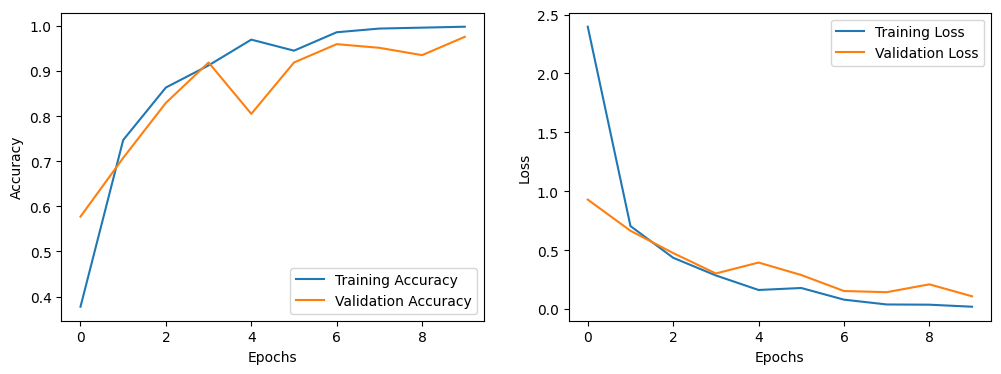

In [17]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
# Step 1: Load a pre-trained VGG19 model with pre-trained weights and without the final classification layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Add your own classification layers on top of the pre-trained VGG19 model
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Step 3: Freeze the pre-trained layers to avoid overfitting on your limited dataset
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Create the fine-tuned model by combining the base VGG19 model with your classification layers
fine_tuned_model = Model(inputs=base_model.input, outputs=output_layer)

# Step 5: Compile the model with a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=0.0001)
fine_tuned_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Save the model to a file (e.g., "my_fine_tuned_model.h5")
model_save_path = "my_fine_tuned_model.h5"
fine_tuned_model.save(model_save_path)

# Fine-tune the model with your training data
batch_size = 32
epochs = 10

history = fine_tuned_model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))

# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = fine_tuned_model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Plot the training history
plot_history(history)

4/4 [==============================] - 1s 167ms/step


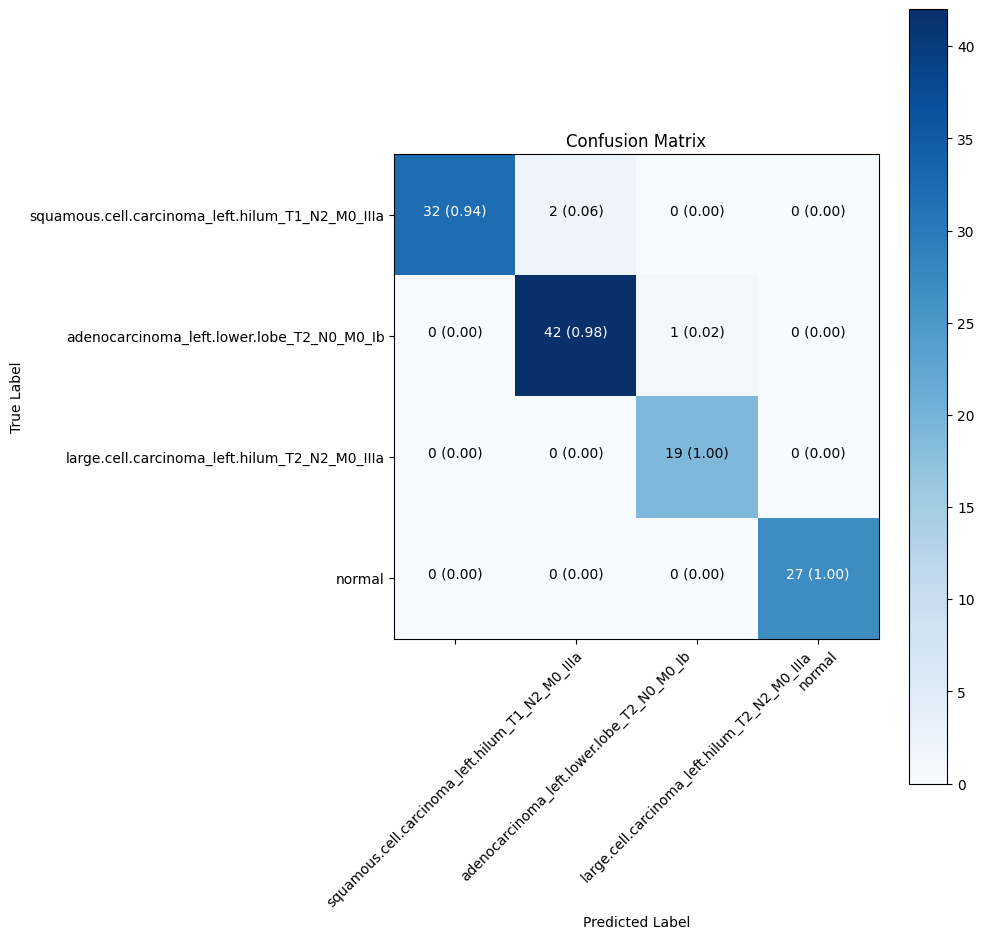

Accuracy: 97.56%


In [18]:
# Assuming you have already fine-tuned your model and obtained predictions on the test set
predictions = fine_tuned_model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)
# Get class labels from the label_to_int dictionary
label_to_int_inv = {v: k for k, v in label_to_int.items()}
classes = [label_to_int_inv[i] for i in range(num_classes)]
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
# Normalize the confusion matrix values for better readability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Use white text for darker cells, and black text otherwise
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + " (" + format(cm_normalized[i, j], '.2f') + ")",
             horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
from sklearn.metrics import accuracy_score
# Compute the accuracy
accuracy = accuracy_score(np.argmax(test_labels, axis=1), predicted_labels)
# Display the accuracy percentage
print("Accuracy: {:.2f}%".format(accuracy * 100))

Please upload a CT scan image:


Saving WhatsApp Image 2023-08-01 at 10.49.21 AM.jpeg to WhatsApp Image 2023-08-01 at 10.49.21 AM (2).jpeg
1/1 [==============================] - 0s 176ms/step


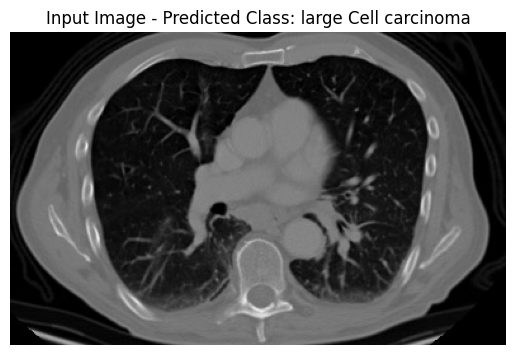

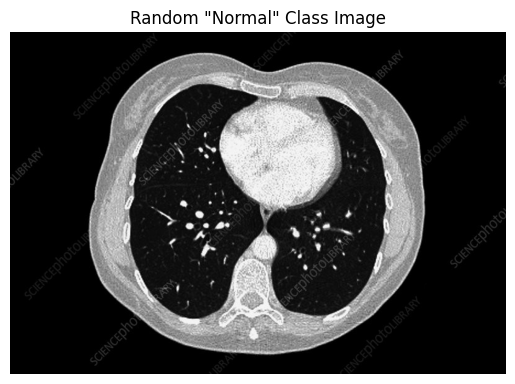

In [23]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from google.colab import files

# Define the label_to_int dictionary to map class labels to integers
label_to_int = {
    "adenocarcinoma": 0,
    "large Cell carcinoma": 1,
    "normal": 2,
    "squamous.cell.carcinoma": 3
}

# Function to preprocess the input image
def preprocess_input_image(image_path, input_shape):
    image = Image.open(image_path)
    image = image.resize(input_shape)
    image = img_to_array(image)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Load the fine-tuned VGG19 model
fine_tuned_model = load_model("my_fine_tuned_model.h5")

# Ask the user to upload an image
print("Please upload a CT scan image:")
uploaded_files = files.upload()

# Get the file path of the uploaded image
input_image_path = list(uploaded_files.keys())[0]

# Preprocess the input image
input_shape = (224, 224)  # VGG19 model input dimensions
input_image = preprocess_input_image(input_image_path, input_shape)

# Use the fine-tuned VGG19 model to predict the class of the input image
predictions = fine_tuned_model.predict(input_image)

# Get the predicted class label based on label_to_int dictionary
predicted_label = list(label_to_int.keys())[np.argmax(predictions)]

# Load and display the input image
input_image = Image.open(input_image_path)
plt.imshow(input_image)
plt.title(f'Input Image - Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()

# Load and display a random "normal" class image
normal_images_path = "/content/chest-ctscan-images/Data/valid/normal/"  # Replace with the path to the directory containing "normal" class images
normal_images = os.listdir(normal_images_path)
random_normal_image = random.choice(normal_images)

# Load and display the random "normal" image
output_image_path = os.path.join(normal_images_path, random_normal_image)
output_image = Image.open(output_image_path)
plt.imshow(output_image)
plt.title('Random "Normal" Class Image')
plt.axis('off')
plt.show()
